# Predicción de tiempos de carrera

## Objetivos  
* Realizar un modelo predictivo basado en algoritmos de aprendizaje supervisado de regresiones que permitan conocer el tiempo estimado en una carrera (distancia) determinada.  
* La calidad de la predicción se medirá a partir del Mayor R2 y Menor MAE.


**IMPORT LIBRARIES:**

In [1]:
#data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing libraries
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline


#model selection and algorithms
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_predict, TimeSeriesSplit

**1. LOADING AND READING DATA:**

* Estos datos han sido obtenidos mediante la aplicación y página web de Garmin, y corresponden a un solo usuario.  
* Los datos que se muestran a continuación son registros de actividades físicas realizadas a partir del 2017 hasta 2022.

In [2]:
df = pd.read_csv("activities_garmin.csv")
pd.options.display.max_columns = 0
df.head()

,Tipo de actividad,Fecha,Favorito,Título,Distancia,Calorías,Tiempo,Frecuencia cardiaca media,Frecuencia cardiaca máxima,Cadencia de carrera media,Cadencia de carrera máxima,Ritmo medio,Ritmo óptimo,Ascenso total,Descenso total,Longitud media de zancada,Relación vertical media,Oscilación vertical media,Tiempo medio de contacto con el suelo,Cadencia de carrera media.1,Cadencia de carrera máxima.1,Training Stress Score®,Potencia media,Potencia máxima,Dificultad,Fluidez,Brazadas totales,Swolf medio,Velocidad media de palada,Repeticiones totales,Series totales,Tiempo de inmersión,Temperatura mínima,Intervalo en superficie,Descompresión,Mejor tiempo de vuelta,Número de vueltas,Temperatura máxima,Ritmo medio de respiración,Ritmo mínimo de respiración,Ritmo máximo de respiración,Cambio en el estrés,Inicio del periodo de estrés,Fin del periodo de estrés,Estrés medio,Tiempo en movimiento,Tiempo transcurrido,Altura mínima,Altura máxima
0,Carrera,2022-10-23 08:18:20,False,Barcelona - 21K TEST,21.23,"1,307",01:27:54,179,198,178,194,4:08,3:31,45,87,1.35,0.0,0.0,0,0,0,0.0,0,0,0.0,0.0,--,0,0,0,--,0:00,0.0,0:00,No,00:51.80.4,22,0.0,--,--,--,--,--,--,--,01:27:34,01:33:59,13,67
1,Carrera,2022-10-22 12:52:41,False,Esplugues de Llobregat - Entrenamiento precomp...,3.36,216,00:16:09,164,175,174,195,4:48,3:21,30,30,1.21,0.0,0.0,0,0,0,0.0,0,0,0.0,0.0,--,0,0,0,--,0:00,0.0,0:00,No,00:11.88.5,15,0.0,--,--,--,--,--,--,--,00:16:07,00:16:09,75,88
2,Ciclismo,2022-10-22 11:40:38,False,Esplugues de Llobregat Ciclismo,30.20,483,01:03:05,132,150,0,0,28.7,39.0,82,75,0.00,0.0,0.0,0,0,0,0.0,0,0,0.0,0.0,--,0,0,0,--,0:00,0.0,0:00,No,00:27.56.9,7,0.0,--,--,--,--,--,--,--,01:03:01,01:08:31,76,88
3,Ciclismo,2022-10-21 21:09:05,False,Esplugues de Llobregat Ciclismo,7.78,160,00:36:16,105,138,0,0,12.9,28.4,35,71,0.00,0.0,0.0,0,0,0,0.0,0,0,0.0,0.0,--,0,0,0,--,0:00,0.0,0:00,No,12:45.67.4,2,0.0,--,--,--,--,--,--,--,00:29:06,00:36:16,40,100
4,Ciclismo,2022-10-21 19:31:36,False,Esplugues de Llobregat Ciclismo,40.46,653,01:21:39,137,161,0,0,29.7,40.5,133,124,0.00,0.0,0.0,0,0,0,0.0,0,0,0.0,0.0,--,0,0,0,--,0:00,0.0,0:00,No,01:11.40.5,9,0.0,--,--,--,--,--,--,--,01:21:16,01:27:45,76,85


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 49 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Tipo de actividad                      1569 non-null   object 
 1   Fecha                                  1569 non-null   object 
 2   Favorito                               1569 non-null   bool   
 3   Título                                 1569 non-null   object 
 4   Distancia                              1569 non-null   object 
 5   Calorías                               1569 non-null   object 
 6   Tiempo                                 1569 non-null   object 
 7   Frecuencia cardiaca media              1569 non-null   int64  
 8   Frecuencia cardiaca máxima             1569 non-null   int64  
 9   Cadencia de carrera media              1569 non-null   object 
 10  Cadencia de carrera máxima             1569 non-null   object 
 11  Ritm

In [4]:
df.nunique()

Tipo de actividad                          16
Fecha                                    1568
Favorito                                    2
Título                                    326
Distancia                                 837
Calorías                                  802
Tiempo                                   1275
Frecuencia cardiaca media                 132
Frecuencia cardiaca máxima                123
Cadencia de carrera media                 117
Cadencia de carrera máxima                106
Ritmo medio                               456
Ritmo óptimo                              390
Ascenso total                             248
Descenso total                            248
Longitud media de zancada                  97
Relación vertical media                     1
Oscilación vertical media                   1
Tiempo medio de contacto con el suelo       1
Cadencia de carrera media.1                 8
Cadencia de carrera máxima.1                8
Training Stress Score®            

El dataset contiene información de actividades físicas registradas mediante un dispositivo garmin (reloj).  
Lo que nos interesa de este Dataset, principalmente es toda la información correspondiente a las actividades de carrera, para las demás actividades solo se considerará los parámetros que coincidan con la carrera, pero no los específicos de cada uno, por lo que se decide eliminar esas columnas (en amarillo) que no aportan ningún tipo de valor para la predicción de carrera: 


<div>
    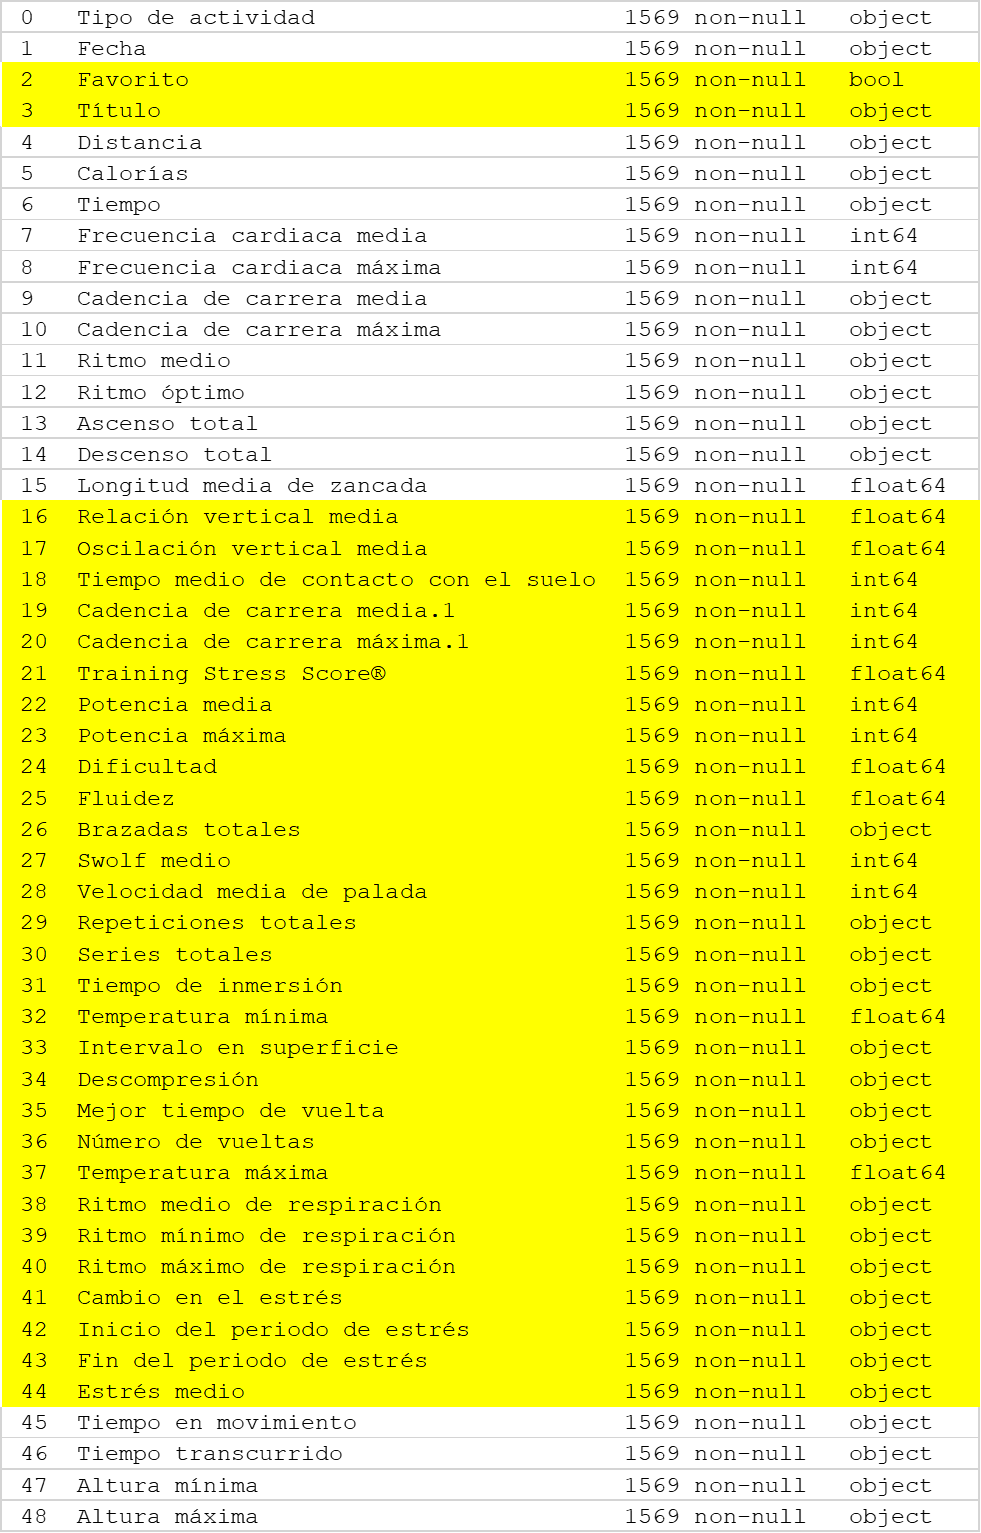
</div>


In [5]:
#Drop columns
df = df.drop(df.columns[[2,3,16,17,18,19,20,21,22,23,
              24,25,26,27,28,29,30,31,32,33,34,35,36,
              37,38,39,40,41,42,43,44, 45, 46]], axis=1)

In [6]:
#Rename columns
df.columns = ['Actividad', 'Fecha', 'Distancia', 'Calorias', 'Tiempo',
       'FC_media', 'FC_max', 'Cadencia_media', 'Cadencia_max',
       'Ritmo_medio', 'Ritmo_optimo', 'Asc_total', 'Desc_total',
       'Long_media_zancada', 'Altura_min', 'Altura_max']
df.head(3)

,Actividad,Fecha,Distancia,Calorias,Tiempo,FC_media,FC_max,Cadencia_media,Cadencia_max,Ritmo_medio,Ritmo_optimo,Asc_total,Desc_total,Long_media_zancada,Altura_min,Altura_max
0,Carrera,2022-10-23 08:18:20,21.23,"1,307",01:27:54,179,198,178,194,4:08,3:31,45,87,1.35,13,67
1,Carrera,2022-10-22 12:52:41,3.36,216,00:16:09,164,175,174,195,4:48,3:21,30,30,1.21,75,88
2,Ciclismo,2022-10-22 11:40:38,30.20,483,01:03:05,132,150,0,0,28.7,39.0,82,75,0.00,76,88


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Actividad           1569 non-null   object 
 1   Fecha               1569 non-null   object 
 2   Distancia           1569 non-null   object 
 3   Calorias            1569 non-null   object 
 4   Tiempo              1569 non-null   object 
 5   FC_media            1569 non-null   int64  
 6   FC_max              1569 non-null   int64  
 7   Cadencia_media      1569 non-null   object 
 8   Cadencia_max        1569 non-null   object 
 9   Ritmo_medio         1569 non-null   object 
 10  Ritmo_optimo        1569 non-null   object 
 11  Asc_total           1569 non-null   object 
 12  Desc_total          1569 non-null   object 
 13  Long_media_zancada  1569 non-null   float64
 14  Altura_min          1569 non-null   object 
 15  Altura_max          1569 non-null   object 
dtypes: flo

**Variables del dataset:**  

* **Features:** El dataset contiene 16 features en 16 columnas, que son los parámetros medidos en el reloj de pulsera garmin. Estos corresponden a las métricas detectadas en las actividades físicas realizadas. 

* **Target:** El target corresponde al **Tiempo** que es la predicción que buscamos obtener.

**Identify Anomalies/ Missing Data**

**Es necesario corregir/ eliminar algunos valores, así como también cambiar el Dtype de las columnas**

Se concideran datos erroneos las filas que contienen **"--"**, para las columnas 'Distancia', 'Calorías', 'Cadencia de carrera media', 'Cadencia de carrera máxima'.  
Para las demás columnas se reemplaza con 0.

In [8]:
df[df == '--'].count()

Actividad               0
Fecha                   0
Distancia               1
Calorias               12
Tiempo                  0
FC_media                0
FC_max                  0
Cadencia_media          3
Cadencia_max            3
Ritmo_medio           247
Ritmo_optimo          275
Asc_total             421
Desc_total            413
Long_media_zancada      0
Altura_min            283
Altura_max            278
dtype: int64

In [9]:
# Para las columnas indicadas
df.drop(df[df['Distancia'] == '--'].index, inplace = True)
df.drop(df[df['Calorias'] == '--'].index, inplace = True)
df.drop(df[df['Cadencia_media'] == '--'].index, inplace = True)
df.drop(df[df['Cadencia_max'] == '--'].index, inplace = True)
#df = df[df.Distancia != '--']
#df = df[df.Calorias != '--']
#df = df[df.Cadencia_media != '--']
#df = df[df.Cadencia_max != '--']

In [10]:
# Para el resto de columnas
df = df.replace('--', 0)

In [11]:
df[df == '--'].count()

Actividad             0
Fecha                 0
Distancia             0
Calorias              0
Tiempo                0
FC_media              0
FC_max                0
Cadencia_media        0
Cadencia_max          0
Ritmo_medio           0
Ritmo_optimo          0
Asc_total             0
Desc_total            0
Long_media_zancada    0
Altura_min            0
Altura_max            0
dtype: int64

In [12]:
df['Actividad'] = df['Actividad'].astype('str')
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['year'] = df['Fecha'].dt.year
df['month'] = df['Fecha'].dt.month
df['day'] = df['Fecha'].dt.day
df['weekday'] = df['Fecha'].dt.dayofweek

df['Distancia'] = df['Distancia'].str.replace(',', '.').astype('float')
df['Calorias'] = df['Calorias'].str.replace(',', '').astype('int64')
df['Tiempo'] = pd.to_timedelta(df['Tiempo']).dt.total_seconds().astype('int64')
df['Cadencia_media'] = df['Cadencia_media'].astype('int64')
df['Cadencia_max'] = df['Cadencia_max'].astype('int64')

df['Asc_total'] = df['Asc_total'].str.replace(',', '').astype('float64')
df['Desc_total'] = df['Desc_total'].str.replace(',', '').astype('float64')

df['Altura_min'] = df['Altura_min'].str.replace(',', '').astype('float64')
df['Altura_max'] = df['Altura_max'].str.replace(',', '').astype('float64')


In [13]:
# Poner los ritmos con formato 00:00:00 y no hacer nada con las velocidades (0.00)
rm = []
for i in df['Ritmo_medio']:
    if ":" in str(i):
        if len(i) == 4:
            i = "00:0"+ i
        elif len(i) == 5:
            i= "00:"+ i
        else:
            i= "0"+ i
        
    rm.append(i)

#asigno valores a columna usando mismo index para poder unir correctamente
df['Ritmo_medio'] = pd.DataFrame(rm, index = df.index)

# del formato 00:00:00 ---> pasar a velocidad
for j in df['Ritmo_medio'].index:
    if ":" in str(df['Ritmo_medio'][j]):
        df['Ritmo_medio'][j] = round(1/(pd.to_timedelta(df['Ritmo_medio'][j]).total_seconds())*3600,2)

# de object a float
df['Ritmo_medio'] = df['Ritmo_medio'].astype('float')

C:\Users\Pepo\AppData\Local\Temp/ipykernel_17324/1469466294.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ritmo_medio'][j] = round(1/(pd.to_timedelta(df['Ritmo_medio'][j]).total_seconds())*3600,2)


In [14]:
# Poner los ritmos con formato 00:00:00 y no hacer nada con las velocidades (0.00)
ro = []
for i in df['Ritmo_optimo']:
    if ":" in str(i):
        if len(i) == 4:
            i = "00:0"+ i
        elif len(i) == 5:
            i= "00:"+ i
        else:
            i= "0"+ i
        
    ro.append(i)

#asigno valores a columna usando mismo index para poder unir correctamente
df['Ritmo_optimo'] = pd.DataFrame(ro, index = df.index)

# del formato 00:00:00 ---> pasar a velocidad
for j in df['Ritmo_optimo'].index:
    if ":" in str(df['Ritmo_optimo'][j]):
        df['Ritmo_optimo'][j] = round(1/(pd.to_timedelta(df['Ritmo_optimo'][j]).total_seconds())*3600,2)

# de object a float
df['Ritmo_optimo'] = df['Ritmo_optimo'].astype('float')

C:\Users\Pepo\AppData\Local\Temp/ipykernel_17324/3239115964.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ritmo_optimo'][j] = round(1/(pd.to_timedelta(df['Ritmo_optimo'][j]).total_seconds())*3600,2)


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Distancia,1555.0,14.103129,61.965399,0.0,4.60,7.86,10.43,975.00
Calorias,1555.0,563.832797,418.041201,0.0,360.00,520.00,674.50,7396.00
Tiempo,1555.0,3776.981994,4259.848437,86.0,2458.00,3287.00,4180.00,108534.00
FC_media,1555.0,136.444373,32.336650,0.0,130.00,147.00,155.00,190.00
FC_max,1555.0,160.192926,33.308338,0.0,156.00,168.00,179.00,210.00
Cadencia_media,1555.0,122.058521,76.043820,0.0,0.00,170.00,177.00,189.00
Cadencia_max,1555.0,147.572990,90.048394,0.0,0.00,190.00,199.00,273.00
Ritmo_medio,1555.0,9.855768,7.211420,0.0,8.09,9.68,11.04,57.14
Ritmo_optimo,1555.0,16.594887,21.452596,0.0,10.40,13.19,16.14,276.92
Asc_total,1144.0,78.760490,177.972656,2.0,11.00,26.00,77.25,2784.00


In [16]:
#Se identifica distancias máximas erroneas. Se investiga que sucede:
df.loc[df['Distancia'] == 975]

,Actividad,Fecha,Distancia,Calorias,Tiempo,FC_media,FC_max,Cadencia_media,Cadencia_max,Ritmo_medio,Ritmo_optimo,Asc_total,Desc_total,Long_media_zancada,Altura_min,Altura_max,year,month,day,weekday
170,Natación en piscina,2022-05-13 14:18:32,975.0,180,2519,110,145,0,0,16.67,80.0,NaN,NaN,0.0,NaN,NaN,2022,5,13,4
174,Natación en piscina,2022-05-10 21:47:18,975.0,194,2711,114,148,0,0,24.00,72.0,NaN,NaN,0.0,NaN,NaN,2022,5,10,1


In [17]:
df.loc[df['Actividad'] == 'Natación en piscina'].tail()

,Actividad,Fecha,Distancia,Calorias,Tiempo,FC_media,FC_max,Cadencia_media,Cadencia_max,Ritmo_medio,Ritmo_optimo,Asc_total,Desc_total,Long_media_zancada,Altura_min,Altura_max,year,month,day,weekday
299,Natación en piscina,2022-02-08 21:07:11,1.200,242,4887,0,0,0,0,30.25,81.82,NaN,NaN,0.0,NaN,NaN,2022,2,8,1
306,Natación en piscina,2022-02-03 21:12:17,1.175,247,4839,0,0,0,0,29.03,76.60,NaN,NaN,0.0,NaN,NaN,2022,2,3,3
310,Natación en piscina,2022-02-01 21:07:19,1.300,267,5474,0,0,0,0,31.30,81.82,NaN,NaN,0.0,NaN,NaN,2022,2,1,1
320,Natación en piscina,2022-01-20 21:54:06,600.000,126,2036,0,0,0,0,29.27,78.26,NaN,NaN,0.0,NaN,NaN,2022,1,20,3
1548,Natación en piscina,2017-02-10 20:55:12,475.000,113,1689,0,0,0,0,23.08,87.80,NaN,NaN,0.0,NaN,NaN,2017,2,10,4


Hace falta corregir los NaN values y las distancias de Natación se deben unificar al resto de distancias y para esto es necesario pasar de metros a kilómetros

In [18]:
# corregir distancia natación: de metros a km
for j in df.index:
    if "Natación" in str(df['Actividad'][j]):
        if df['Distancia'][j] >= 100:
            df['Distancia'][j] = (df['Distancia'][j])/1000

C:\Users\Pepo\AppData\Local\Temp/ipykernel_17324/1559852226.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distancia'][j] = (df['Distancia'][j])/1000


In [19]:
df.fillna(0,inplace=True)

Con el DataFrame listo, realizo una copia solamente de que contenga la Actividad Carrera, misma que me servirá para obtener información y realizar gráficas más adelante

In [20]:
gf = df.loc[df['Actividad'] == 'Carrera']

**2. PREPOCESSING THE DATA:**

Es importante conocer que tipo de distribución tienen los features, así como la existencia de outliers, para determinar el tipo de preprocesado a realizar.

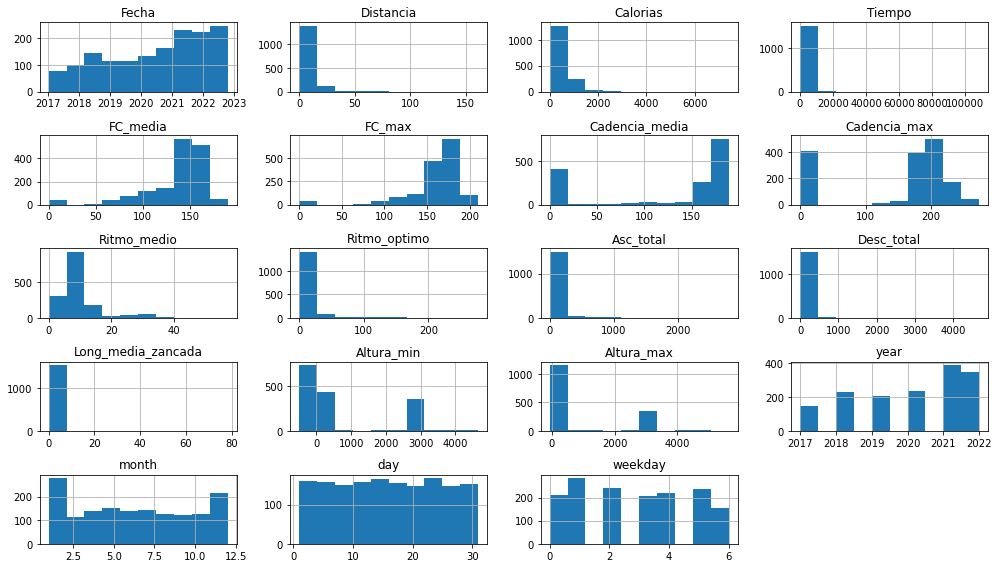

In [21]:
df.hist(figsize=(14,8))
plt.tight_layout()

* Visualmente, parecen no ser distribuciones gaussianas, sin embargo corroboramos mediante p-test.


In [22]:
# Selecciono las columnas numéricas
df1 = df.iloc[:, 2:]

In [23]:
# Shapiro-Wilk Normality Test
for i in df1.columns:
    stat, p = shapiro(df[i])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(i, ': Probably Gaussian')
    else:
        print(i, ': Probably not Gaussian')

stat=0.611, p=0.000
Distancia : Probably not Gaussian
stat=0.670, p=0.000
Calorias : Probably not Gaussian
stat=0.296, p=0.000
Tiempo : Probably not Gaussian
stat=0.780, p=0.000
FC_media : Probably not Gaussian
stat=0.710, p=0.000
FC_max : Probably not Gaussian
stat=0.672, p=0.000
Cadencia_media : Probably not Gaussian
stat=0.710, p=0.000
Cadencia_max : Probably not Gaussian
stat=0.790, p=0.000
Ritmo_medio : Probably not Gaussian
stat=0.523, p=0.000
Ritmo_optimo : Probably not Gaussian
stat=0.354, p=0.000
Asc_total : Probably not Gaussian
stat=0.275, p=0.000
Desc_total : Probably not Gaussian
stat=0.090, p=0.000
Long_media_zancada : Probably not Gaussian
stat=0.586, p=0.000
Altura_min : Probably not Gaussian
stat=0.604, p=0.000
Altura_max : Probably not Gaussian
stat=0.891, p=0.000
year : Probably not Gaussian
stat=0.946, p=0.000
month : Probably not Gaussian
stat=0.956, p=0.000
day : Probably not Gaussian
stat=0.921, p=0.000
weekday : Probably not Gaussian


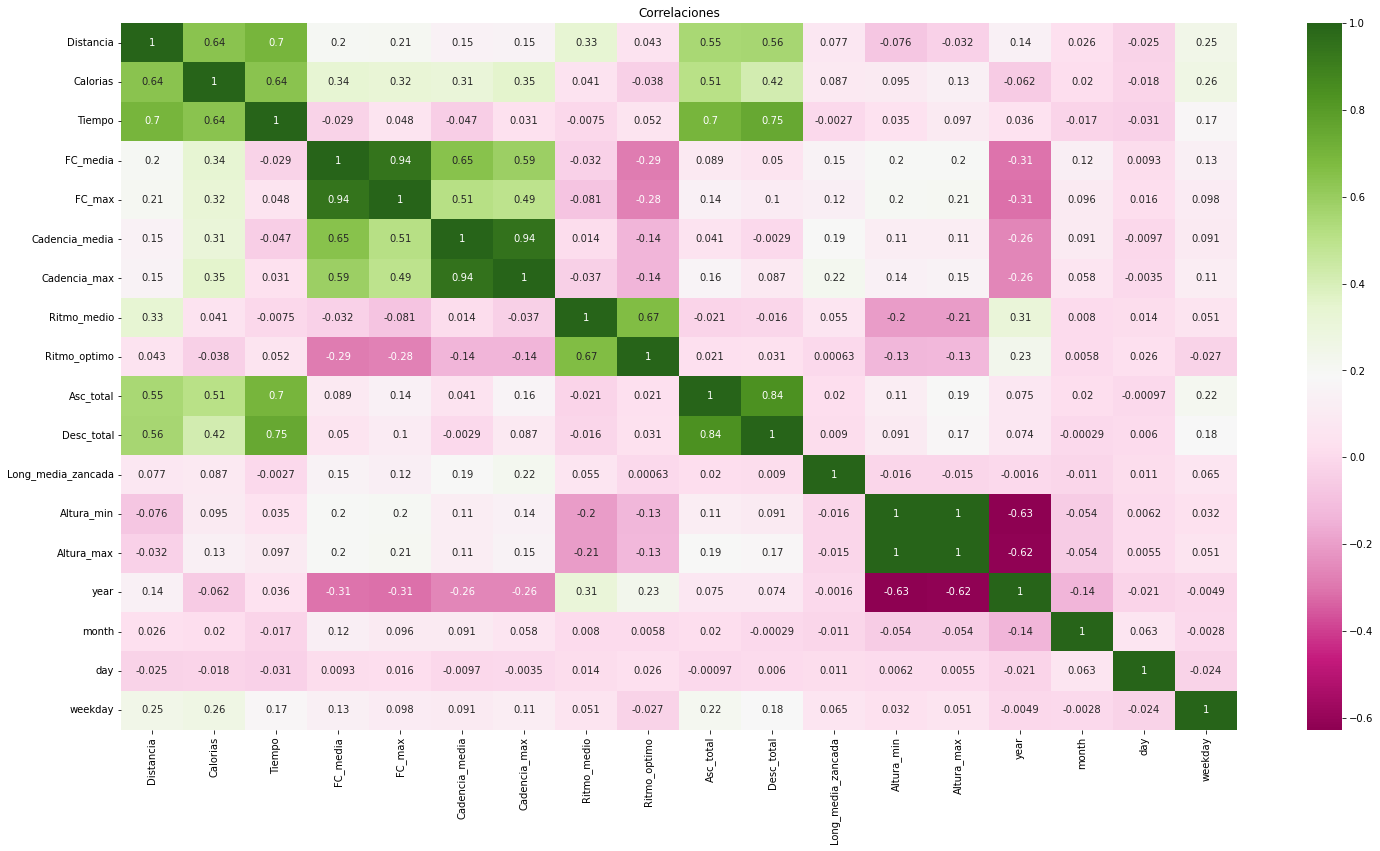

In [24]:
plt.figure(figsize = (25, 13))
sns.heatmap(df1.corr(), annot = True, cmap = "PiYG").set(
    title = "Correlaciones")
plt.savefig("Correlaciones.png")

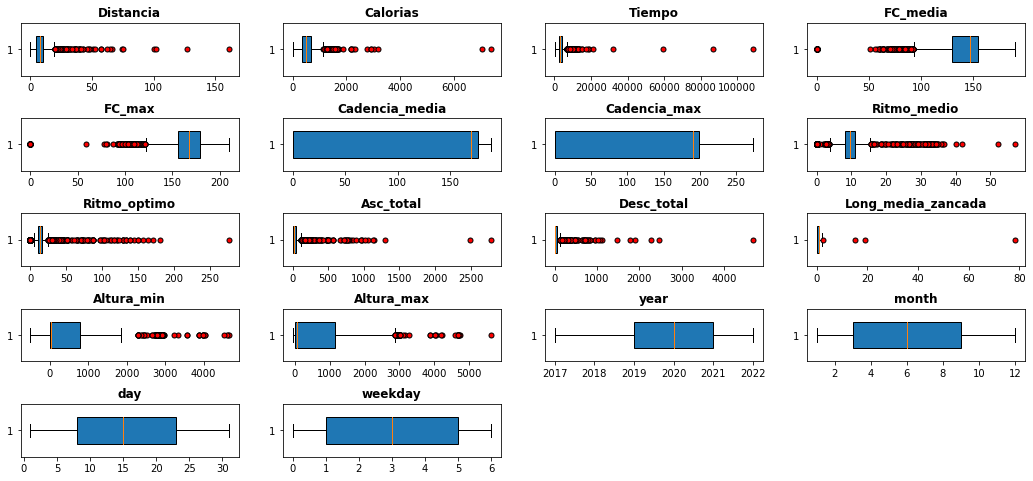

In [25]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='black', ms=5)

fig, axes = plt.subplots(9, 4, figsize=(18, 15))

for idx, (col, ax) in enumerate(zip(df1.columns, axes.flatten())):
    ax.boxplot(df[col], flierprops=red_circle, vert=False,
              patch_artist=True, notch = False, widths = 0.5)
    ax.set_title(col, fontweight='bold')
    plt.subplots_adjust(wspace=.2, hspace=.8)
else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

**Es necesario realizar diferentes tipos de preprocesado según cada columna:**
* Columnas categóricas --> OneHotEncoder
* Columnas con outliers --> RobustScaler
* Columnas sin outliers --> MinMaxScaler


In [26]:
#Seleccionamos las columnas
categorical_columns = ['Actividad']
    
no_outlier_columns = ["Cadencia_media", "Cadencia_max", "year",
    "month", "day", "weekday"]

#definimos las transformaciones a realizar
onehot = OneHotEncoder(handle_unknown='ignore')
MinMax = MinMaxScaler()

In [27]:
# define the data preparation for the columns
preprocessor = ColumnTransformer(
                [('Categorical', onehot, categorical_columns),
                ('MinMaxScaler', MinMax, no_outlier_columns)],
                remainder = RobustScaler())

* Definimos features y target:

In [28]:
X = df.drop(['Tiempo', 'Fecha'],axis=1) #features
y = df['Tiempo'] #Target
print("Shape X:", X.shape,"\nShape y:", y.shape)

Shape X: (1555, 18) 
Shape y: (1555,)


**4. CREATE MODEL**

In [29]:
# define the model
KNR = KNeighborsRegressor()
SVM = SVR()
RFR = RandomForestRegressor(random_state=42)

In [30]:
# define the data preparation and modeling pipeline
KNR_pipeline = Pipeline([('prep',preprocessor), ('KNR', KNR)])
SVM_pipeline = Pipeline([('prep',preprocessor), ('SVM', SVM)])
RFR_pipeline = Pipeline([('prep',preprocessor), ('RFR', RFR)])

In [31]:
models = [
    ("KNR", KNR_pipeline),
    ("SVM", SVM_pipeline),
    ("RFR", RFR_pipeline)
    ]

**Time-based cross-validation**  
Dado que el conjunto de datos es un registro de eventos ordenado en el tiempo, utilizaremos una división de validación cruzada basada en el tiempo para evaluar nuestro modelo de previsión de la demanda de la forma más realista posible. También limitamos el tamaño del conjunto de prueba, ya que no todos los eventos son carreras que se corren al máximo.

In [32]:
# define the model cross-validation configuration
ts_cv = TimeSeriesSplit(
                n_splits=5,
                gap=0,
                max_train_size=None,
                test_size=100)

In [33]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"R2 accuracy:             {r2.mean():.3f} +/- {r2.std():.3f}"
    )

In [82]:
cv_results

{'fit_time': array([313.32954478, 281.5025754 , 321.06313539, 436.87928295,
        467.25120187]),
 'score_time': array([0.04986691, 0.04188848, 0.04089022, 0.07081127, 0.07879114]),
 'test_r2': array([0.74186393, 0.89547774, 0.9059594 , 0.70779019, 0.89224852]),
 'test_neg_mean_absolute_error': array([-229.16137566, -225.44753165, -295.93132911, -531.44455782,
        -219.76877551])}

In [34]:
for name, model in models:
    print(name)
    evaluate(model, X, y, ts_cv)

KNR
Mean Absolute Error:     584.850 +/- 185.437
R2 accuracy:             0.557 +/- 0.130
SVM
Mean Absolute Error:     979.579 +/- 246.133
R2 accuracy:             -0.061 +/- 0.083
RFR
Mean Absolute Error:     303.543 +/- 120.968
R2 accuracy:             0.822 +/- 0.087


A continuación, se hará un gridsearch para ajustar los hiperparámetros de cada algoritmo de manera que estos den **R2** lo más alto posible, y un **MAE** lo más bajo. También se hará una validación cruzada (cross validation) para asegurar esos datos. Se entrenará cada modelo con el subgrupo train, se probará en el test y se calcularán las métricas. Despues de calcular todos estos datos, se añadirán a un diccionario con el que luego se creará un DataFrame que permitirá visualizar los resultados. Ese será, pues, el modelo que se utilizará para entrenar todo el conjunto de datos y se utilizará para predecir el target.

In [35]:
#kneighbors hyperparameters
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 20, num = 2)]
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size = [int(x) for x in np.linspace(start = 5, stop = 50, num = 2)]
p = [int(x) for x in np.linspace(start = 1, stop = 4, num = 1)]
knr_params = {"KNR__n_neighbors": n_neighbors,
              "KNR__weights": weights,
              "KNR__algorithm": algorithm,
              "KNR__leaf_size": leaf_size,
              "KNR__p": p
             }

#SVM hyperparameters
C = [x for x in np.arange(0.1, 2, 0.2)]
kernel = ["linear", "poly", "rbf", "sigmoid"]
degree = [1,2,3,4]
svm_params = {"SVM__C": C,
              "SVM__kernel": kernel,
              "SVM__degree": degree
             }

#random forest hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 75, stop = 200, num = 25)]
max_features = ["auto", "sqrt"]
rfr_params = {"RFR__n_estimators": n_estimators,
             "RFR__max_features": max_features,
            }

In [36]:
#dictionary with all the hyperparameters
hypertuned_params = {"KNR": knr_params,
                     "SVM": svm_params,
                     "RFR": rfr_params,
                    }

In [37]:
# list that contains the rows for the dataframe
rows_list = []

#for gridsearch and cross validation score 
cv = ts_cv
scoring = ['r2', 'neg_mean_absolute_error']


In [38]:
for name, model in models:

    #get hyper parameters
    if name in hypertuned_params.keys():
        random_grid = hypertuned_params[name]
    else:
        continue

    #train nested cross validation and gridsearch  
    clf = GridSearchCV(estimator = model, param_grid = random_grid, cv = cv, scoring = scoring, refit="neg_mean_absolute_error")
    
    clf.fit(X, y)
    
    cv_results = cross_validate(clf, X, y, cv = cv, scoring = scoring)
        
    MAE = -cv_results["test_neg_mean_absolute_error"]
    R2 = cv_results["test_r2"]
    print(
        name, 
        f"Mean Absolute Error:     {MAE.mean():.3f} +/- {MAE.std():.3f}\n"
        f"R2 accuracy:             {R2.mean():.3f} +/- {R2.std():.3f}"
    )
    
    
    #add to dictionary for final dataframe
    results_dict = {"Classifier_Name": name,
                    "R2": cv_results['test_r2'].mean(),
                    "MAE": -cv_results['test_neg_mean_absolute_error'].mean(),
                   
                   }
    rows_list.append(results_dict)

KNR Mean Absolute Error:     595.596 +/- 176.638
R2 accuracy:             0.448 +/- 0.260
SVM Mean Absolute Error:     480.993 +/- 133.651
R2 accuracy:             0.701 +/- 0.123
RFR Mean Absolute Error:     300.351 +/- 118.824
R2 accuracy:             0.829 +/- 0.086


In [39]:
#create dataframe with dictionary content
df_results = pd.DataFrame(rows_list)

In [40]:
round(df_results,2)

,Classifier_Name,R2,MAE
0,KNR,0.45,595.60
1,SVM,0.70,480.99
2,RFR,0.83,300.35


In [41]:
#save to csv to access it later
df_results.to_csv("results_running.csv")

In [42]:
#get row with highest R2 score 
df_results.loc[df_results["R2"].idxmax()]

Classifier_Name           RFR
R2                   0.828668
MAE                300.350714
Name: 2, dtype: object

**MODELO FINAL**

In [43]:
#gridsearch for the definitive model
clf = GridSearchCV(estimator = RFR_pipeline, param_grid = rfr_params, cv = cv, scoring = "neg_mean_absolute_error")

#retrain with all the data
result = clf.fit(X, y)

In [44]:
clf.best_params_

{'RFR__max_features': 'auto', 'RFR__n_estimators': 147}

In [45]:
print("NEG_MAE: ", -result.best_score_.round(2))

NEG_MAE:  298.97


**PREDICTION DATA INPUT**

A continuación, se generan diferentes gráficas para visualizar los datos de carrera que nos hacen falta como inputs:


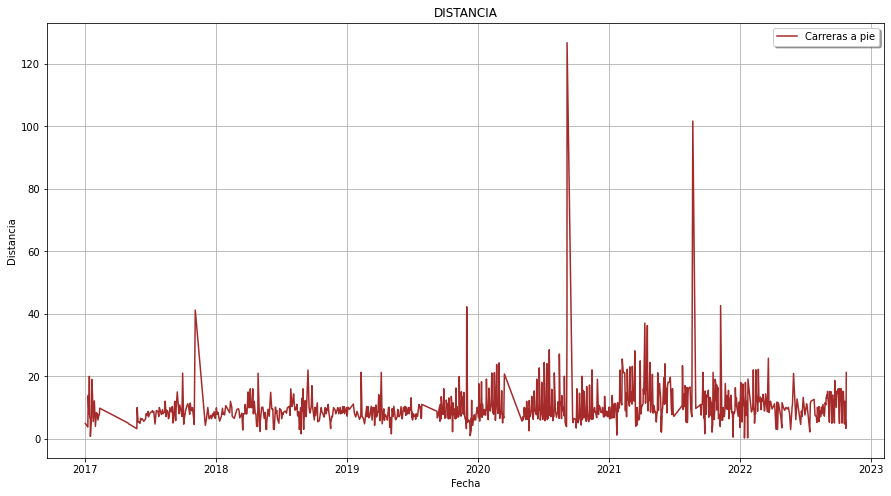

<Figure size 432x288 with 0 Axes>

In [46]:
plt.figure(figsize = (15,8))

plt.plot(gf['Fecha'],gf['Distancia'] , linewidth=1.5, label="Carreras a pie", c="brown")

plt.title("DISTANCIA")
plt.xlabel('Fecha')
plt.ylabel('Distancia')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()
plt.savefig("Distancias.png")

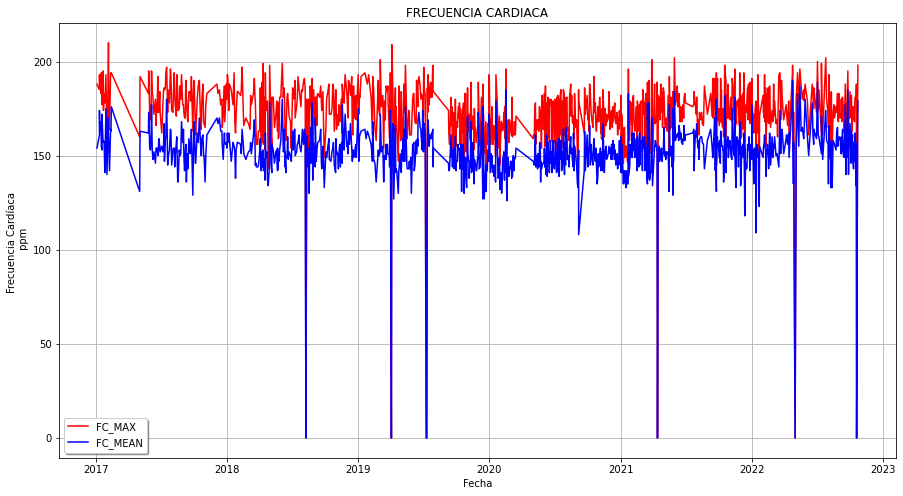

<Figure size 432x288 with 0 Axes>

In [47]:
plt.figure(figsize = (15,8))

plt.plot(gf['Fecha'],gf['FC_max'] , linewidth=1.5, label="FC_MAX", c="r")
plt.plot(gf['Fecha'], gf['FC_media'], linewidth=1.5, label="FC_MEAN", c="blue")


plt.title("FRECUENCIA CARDIACA")
plt.xlabel('Fecha')
plt.ylabel('Frecuencia Cardíaca \n ppm')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()
plt.savefig("FC.png")


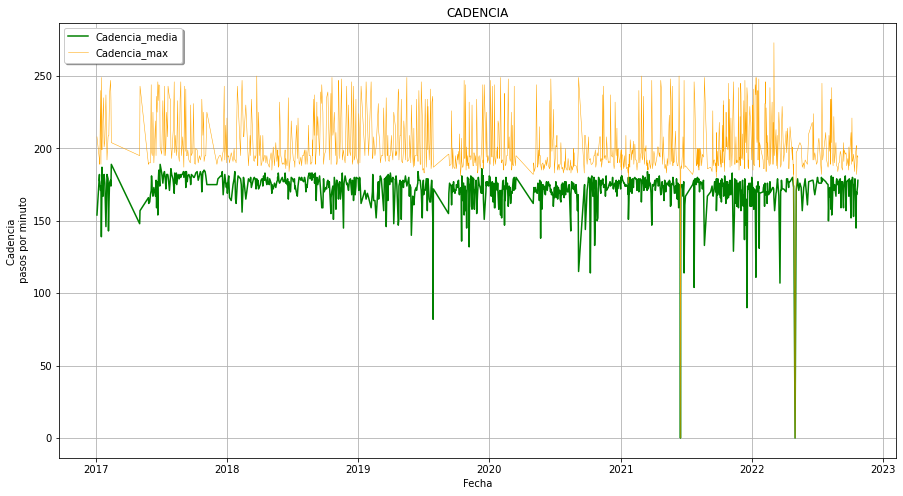

In [48]:
plt.figure(figsize = (15,8))

plt.plot(gf['Fecha'],gf['Cadencia_media'] , linewidth=1.5, label="Cadencia_media", c="g")
plt.plot(gf['Fecha'], gf['Cadencia_max'], linewidth=0.5, label="Cadencia_max", c="orange")

plt.title("CADENCIA")
plt.xlabel('Fecha')
plt.ylabel('Cadencia \n pasos por minuto')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.savefig("Cadencias.png")

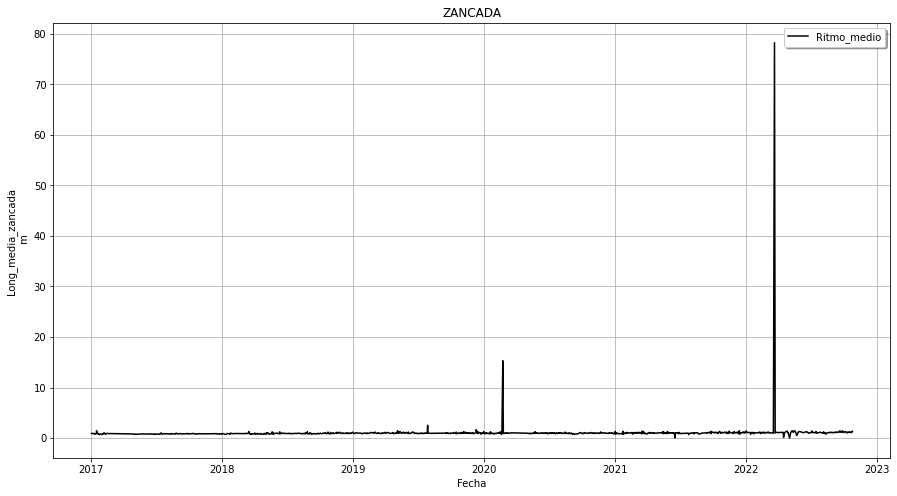

In [49]:
plt.figure(figsize = (15,8))

plt.plot(gf['Fecha'], gf['Long_media_zancada'] , linewidth=1.5, label="Ritmo_medio", c="black")

plt.title("ZANCADA")
plt.xlabel('Fecha')
plt.ylabel('Long_media_zancada \n m')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.savefig("Zancada.png")
plt.show()

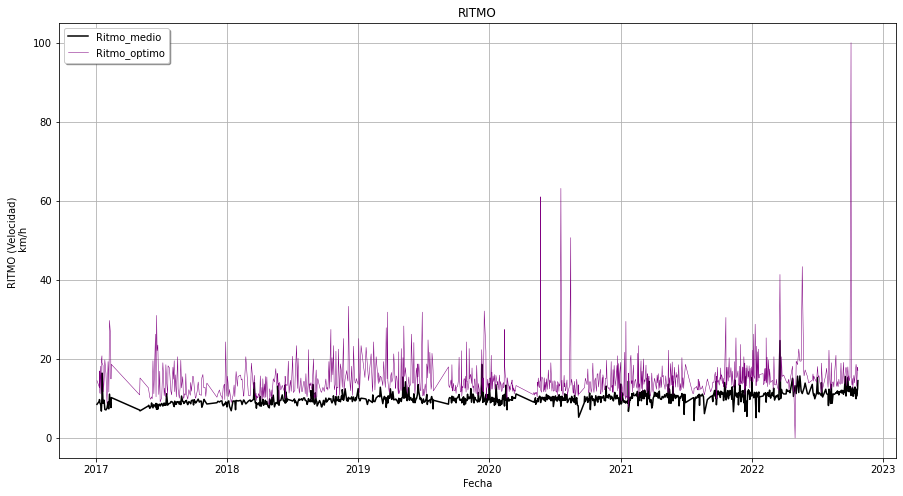

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure(figsize = (15,8))

plt.plot(gf['Fecha'], gf['Ritmo_medio'] , linewidth=1.5, label="Ritmo_medio", c="black")
plt.plot(gf['Fecha'], gf['Ritmo_optimo'], linewidth=0.5, label="Ritmo_optimo", c="purple")

plt.title("RITMO")
plt.xlabel('Fecha')
plt.ylabel('RITMO (Velocidad) \n km/h')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()
plt.savefig("Ritmos.png")

In [51]:
gf.describe().T

,count,mean,std,min,25%,50%,75%,max
Distancia,1027.0,10.013554,6.719694,0.26,6.99,8.90,11.05,126.77
Calorias,1027.0,663.752678,439.419759,0.00,457.00,592.00,734.00,7396.00
Tiempo,1027.0,3672.720545,3626.219794,165.00,2516.00,3227.00,3922.50,86810.00
FC_media,1027.0,151.331061,16.183928,0.00,146.00,152.00,158.00,190.00
FC_max,1027.0,172.243427,18.610744,0.00,165.00,173.00,182.00,210.00
Cadencia_media,1027.0,171.747809,13.051991,0.00,169.50,175.00,178.00,189.00
Cadencia_max,1027.0,201.330088,19.985987,0.00,189.00,195.00,208.00,273.00
Ritmo_medio,1027.0,10.088676,1.547188,4.43,9.21,9.92,10.81,24.66
Ritmo_optimo,1027.0,14.831918,5.215412,0.00,12.18,13.90,15.86,100.00
Asc_total,1027.0,64.135346,142.519053,0.00,9.00,23.00,64.50,2490.00


Los siguientes datos, son valores que conocemos.  
Usaremos la distancia y el peso en kg para determinar un valor aproximado de calorías.

In [180]:
df2 = []

In [181]:
D = float(input("Ingresar distancia en km: "))
W = float(input("Ingresar peso propio en kg: "))

Asc_total = float(input("Ingresar ascenso acumulado total en m: "))
Desc_total = float(input("Ingresar descenso acumulado total en m: "))

Alt_min = float(input("Ingresar altura mínima (msnm): "))
Alt_max = float(input("Ingresar altura máxima (msnm): "))

YY = int(input("Ingresar el año yyyy: "))
MM = int(input("Ingresar el mes mm: "))
DD = int(input("Ingresar el día dd: "))
WD = int(input("Ingresar el # del día de la semana d: "))

Ingresar distancia en km: 21.1
Ingresar peso propio en kg: 63
Ingresar ascenso acumulado total en m: 150
Ingresar descenso acumulado total en m: 148
Ingresar altura mínima (msnm): 220
Ingresar altura máxima (msnm): 312
Ingresar el año yyyy: 2022
Ingresar el mes mm: 11
Ingresar el día dd: 20
Ingresar el # del día de la semana d: 7


Los siguientes valores son tomados dentro de los últimos 60 registros (2 meses aproximadamente), y tomando los valores más elevados. Para evitar errores tomaremos la mediana de los valores y así no considerar ese valor atípico que se observó en algunas gráficas.

In [182]:
calorias = round(D*W,0)
fc_media = (gf['FC_media'].head(60)).nlargest(3, keep='all').median()
fc_max = (gf['FC_max'].head(60)).nlargest(3, keep='all').median()
cad_media = (gf['Cadencia_media'].head(60)).nlargest(3, keep='all').median()
    #En una carrera de competición la cadencia máxima no excede más de 10 puntos a la cadencia media
cad_max = cad_media + 10
rit_medio = (gf['Ritmo_medio'].head(60)).nlargest(5, keep='all').median()
rit_max = rit_medio
long_zan = (gf['Long_media_zancada'].head(60)).nlargest(5, keep='all').median()


In [183]:
Act = "Carrera"

In [184]:
print(D, calorias, fc_media, fc_max, cad_media, cad_max, rit_medio, rit_max, Asc_total, Desc_total,
      long_zan, Alt_min, Alt_max, YY, MM, DD, WD)

21.1 1329.0 179.0 199.0 180.0 190.0 14.52 14.52 150.0 148.0 1.35 220.0 312.0 2022 11 20 7


In [185]:
df2 = np.array([[Act,
                D, calorias, fc_media, fc_max,
                cad_media, cad_max, rit_medio,
                rit_max, Asc_total, Desc_total,
                long_zan, Alt_min, Alt_max, 
                YY, MM, DD, WD ]])
df2 = pd.DataFrame(df2)

In [186]:
df2.columns = ['Actividad', 'Distancia', 'Calorias', 
       'FC_media', 'FC_max', 'Cadencia_media', 'Cadencia_max',
       'Ritmo_medio', 'Ritmo_optimo', 'Asc_total', 'Desc_total',
       'Long_media_zancada', 'Altura_min', 'Altura_max', 'year', 
        'month', 'day', 'weekday']

In [187]:
#predict target 
prediction = clf.predict(df2)

#create dataframe with predictions
pred_df = pd.DataFrame(data = prediction, columns = ["TIEMPO_ESTIMADO"])

#save as csv 
#pred_df.to_csv("RUNNING_prediction.csv")


In [188]:
pred_df['TIEMPO_ESTIMADO'] = pd.to_datetime(pred_df["TIEMPO_ESTIMADO"], unit='s').dt.strftime("%H:%M:%S")
pred_df['DISTANCIA'] = D
pred_df

,TIEMPO_ESTIMADO,DISTANCIA
0,01:32:45,21.1


**Variable Importances**

Analizar la importancia de las variables del modelo utilizado:

In [100]:
# Instantiate model
rf = Pipeline([('prep',preprocessor), 
               ('RFR', RandomForestRegressor(n_estimators = 147, max_features = "auto", random_state = 42))])

# Train the model on training data
rf.fit(X, y);

In [166]:
#features names

#Get OneHot Features Name
onehotfeatures = rf.named_steps['prep'].transformers_[0][1]\
   .get_feature_names(categorical_columns)

#Total names 
feature_list = list(onehotfeatures) + list((X.drop(['Actividad'],axis=1)).columns)

In [168]:
# Get numerical feature importances
importances = list(rf.steps[1][1].feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Ritmo_medio          Importance: 0.45
Variable: Ritmo_optimo         Importance: 0.32
Variable: Altura_max           Importance: 0.08
Variable: year                 Importance: 0.04
Variable: Asc_total            Importance: 0.03
Variable: Distancia            Importance: 0.02
Variable: Long_media_zancada   Importance: 0.01
Variable: Altura_min           Importance: 0.01
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.01
Variable: weekday              Importance: 0.01
Variable: Actividad_Caminar    Importance: 0.0
Variable: Actividad_Cardio     Importance: 0.0
Variable: Actividad_Carrera    Importance: 0.0
Variable: Actividad_Ciclismo   Importance: 0.0
Variable: Actividad_Ciclismo en sala Importance: 0.0
Variable: Actividad_Entrenamiento en cinta Importance: 0.0
Variable: Actividad_Entreno de fuerza Importance: 0.0
Variable: Actividad_Esquí/snowboard Importance: 0.0
Variable: Actividad_Gimnasio y equipo de fitness Importance: 0.0
V

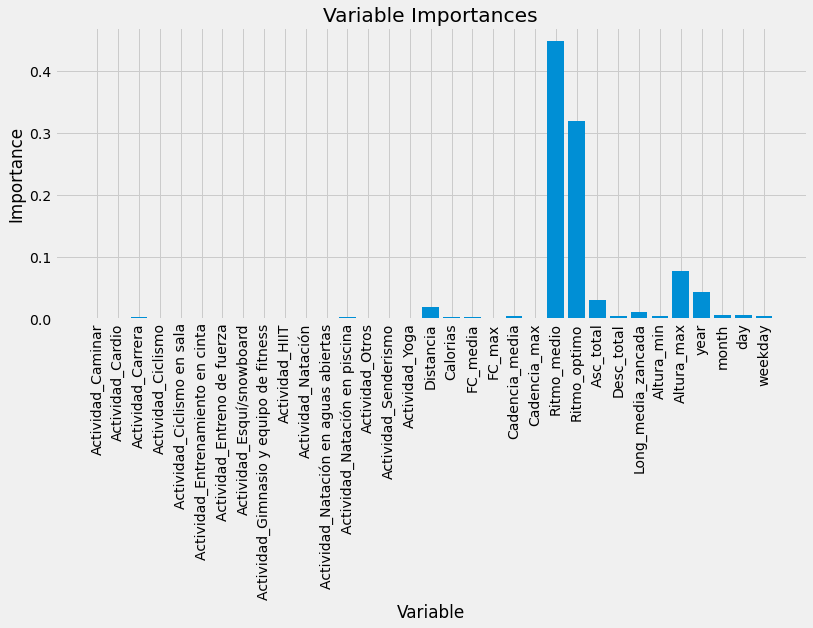

In [170]:
plt.figure(figsize = (12,5))

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

plt.savefig("Variable_Importances.png", bbox_inches='tight')